<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Estudios)](#Analisis-por-grupo-de-indicadores-(estudios))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Estudios Obligatorios)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Estudios_Obligatorios']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6132 entries, 1752 to 7883
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Any                    6132 non-null   int64  
 1   Trimestre              6132 non-null   int64  
 2   Mes                    6132 non-null   int64  
 3   Codi_Districte         6132 non-null   int64  
 4   Nom_Districte          6132 non-null   object 
 5   Codi_Barri             6132 non-null   int64  
 6   Nom_Barri              6132 non-null   object 
 7   Compraventa_Unitario   6132 non-null   float64
 8   Estudios_Obligatorios  6132 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 479.1+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,,,,,,,,
2016-01-01,2016,1,1,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-02-01,2016,1,2,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-03-01,2016,1,3,1,Ciutat Vella,1,el Raval,2813.0,97.2
2016-04-01,2016,2,4,1,Ciutat Vella,1,el Raval,2948.8,97.2
2016-05-01,2016,2,5,1,Ciutat Vella,1,el Raval,2948.8,97.2


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-01-01,1511.900000,94.1
2016-02-01,1511.900000,94.1
2016-03-01,1511.900000,94.1
2016-04-01,1633.069231,94.1
2016-05-01,1633.069231,94.1


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2016-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Compraventa_Unitario   84 non-null     float64
 1   Estudios_Obligatorios  84 non-null     float64
dtypes: float64(2)
memory usage: 2.0 KB


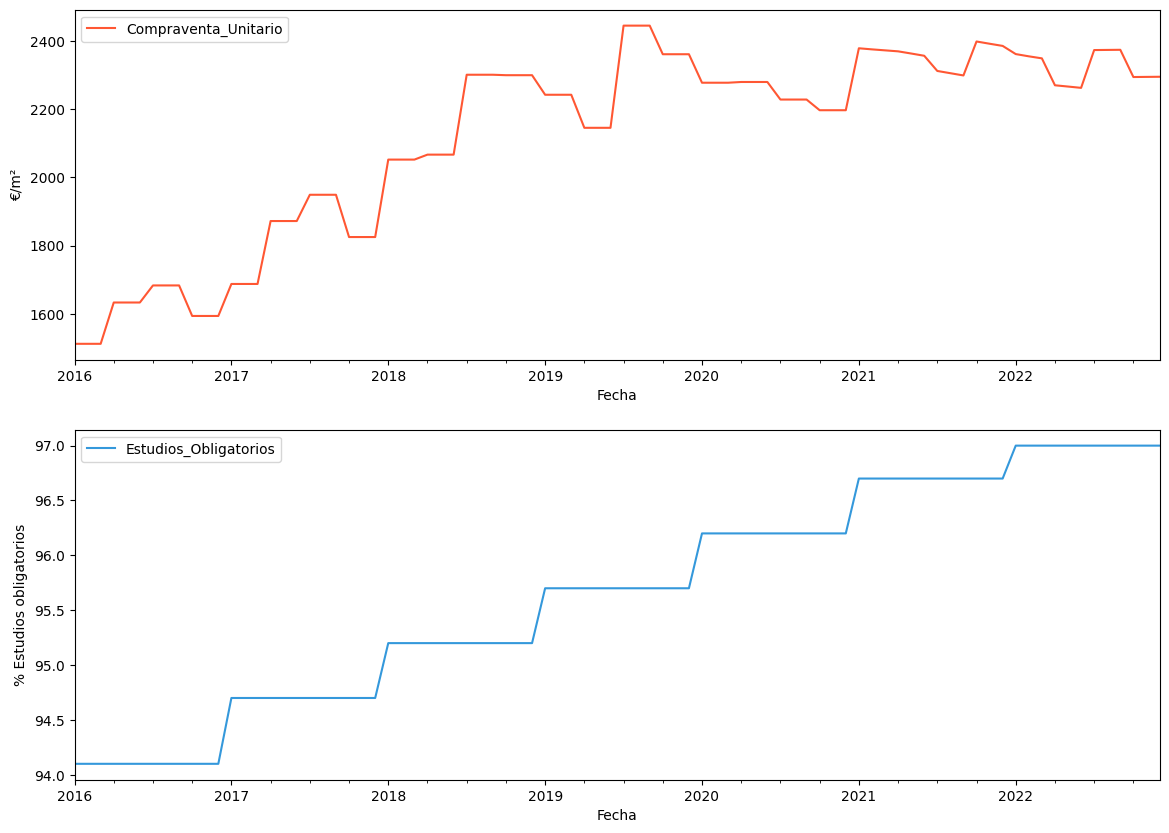

In [17]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Estudios obligatorios' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Ambas series temporales muestran una tendencia al alza

In [18]:
corr=df.corr()
corr

,Compraventa_Unitario,Estudios_Obligatorios
Compraventa_Unitario,1.00000,0.86178
Estudios_Obligatorios,0.86178,1.00000


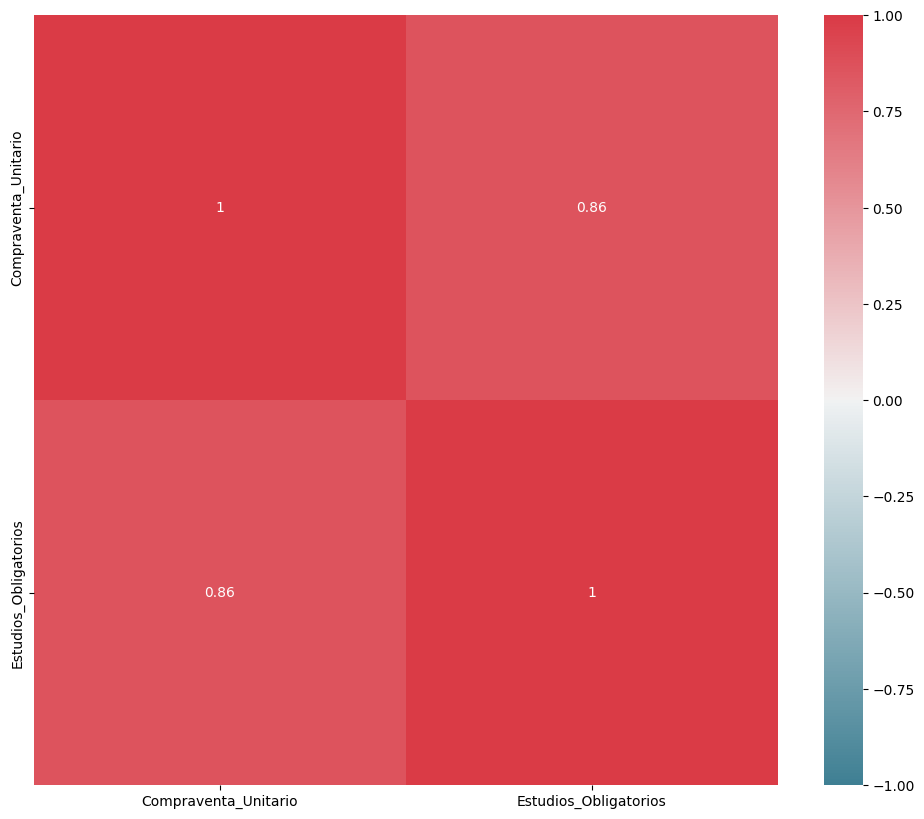

In [15]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

Tambien podemos observar como las 2 variables tienen una alta correlacion, concretamente un 86% de correlacion

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [19]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(72, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [20]:
import statsmodels.tsa.stattools as sts

In [21]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Estudios_Obligatorios
p-value: 0.906536


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [22]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


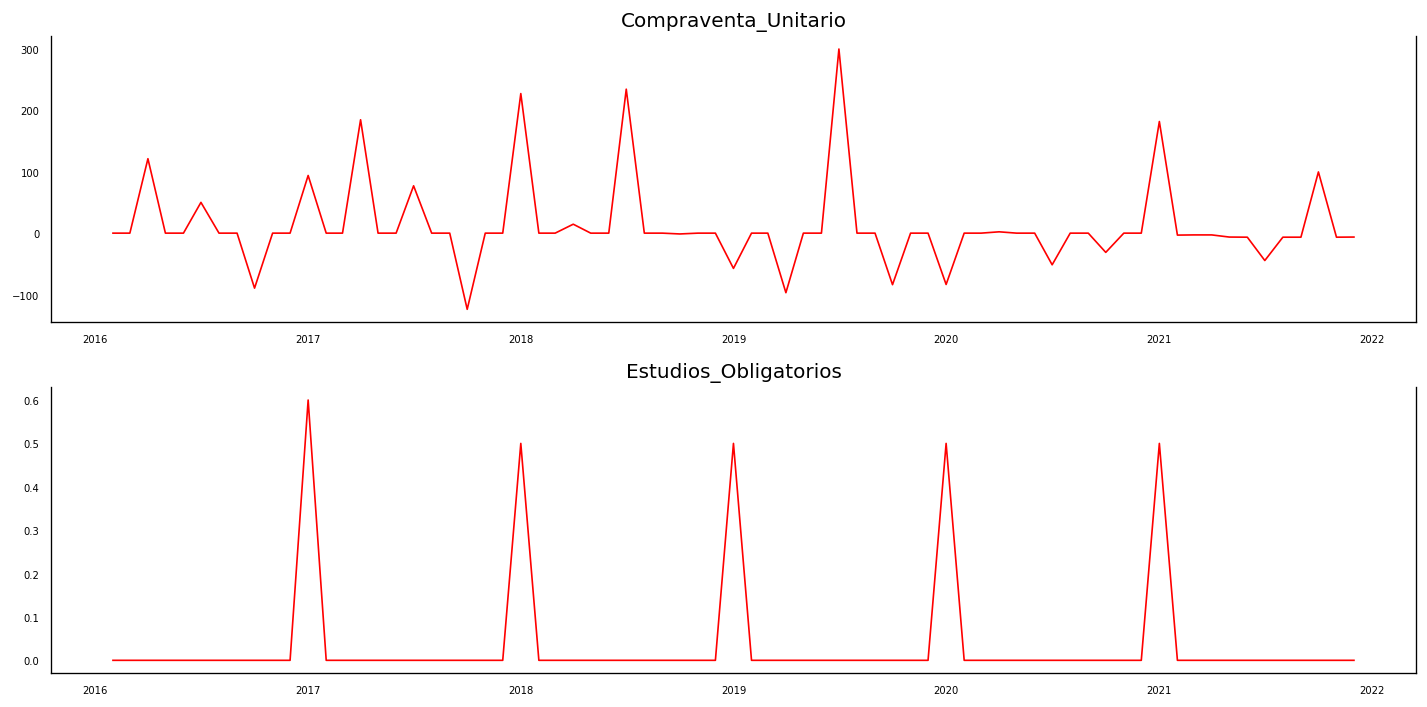

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.255095


In [25]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,-121.169231,0.0
2016-06-01,0.000000,0.0
2016-07-01,50.076923,0.0


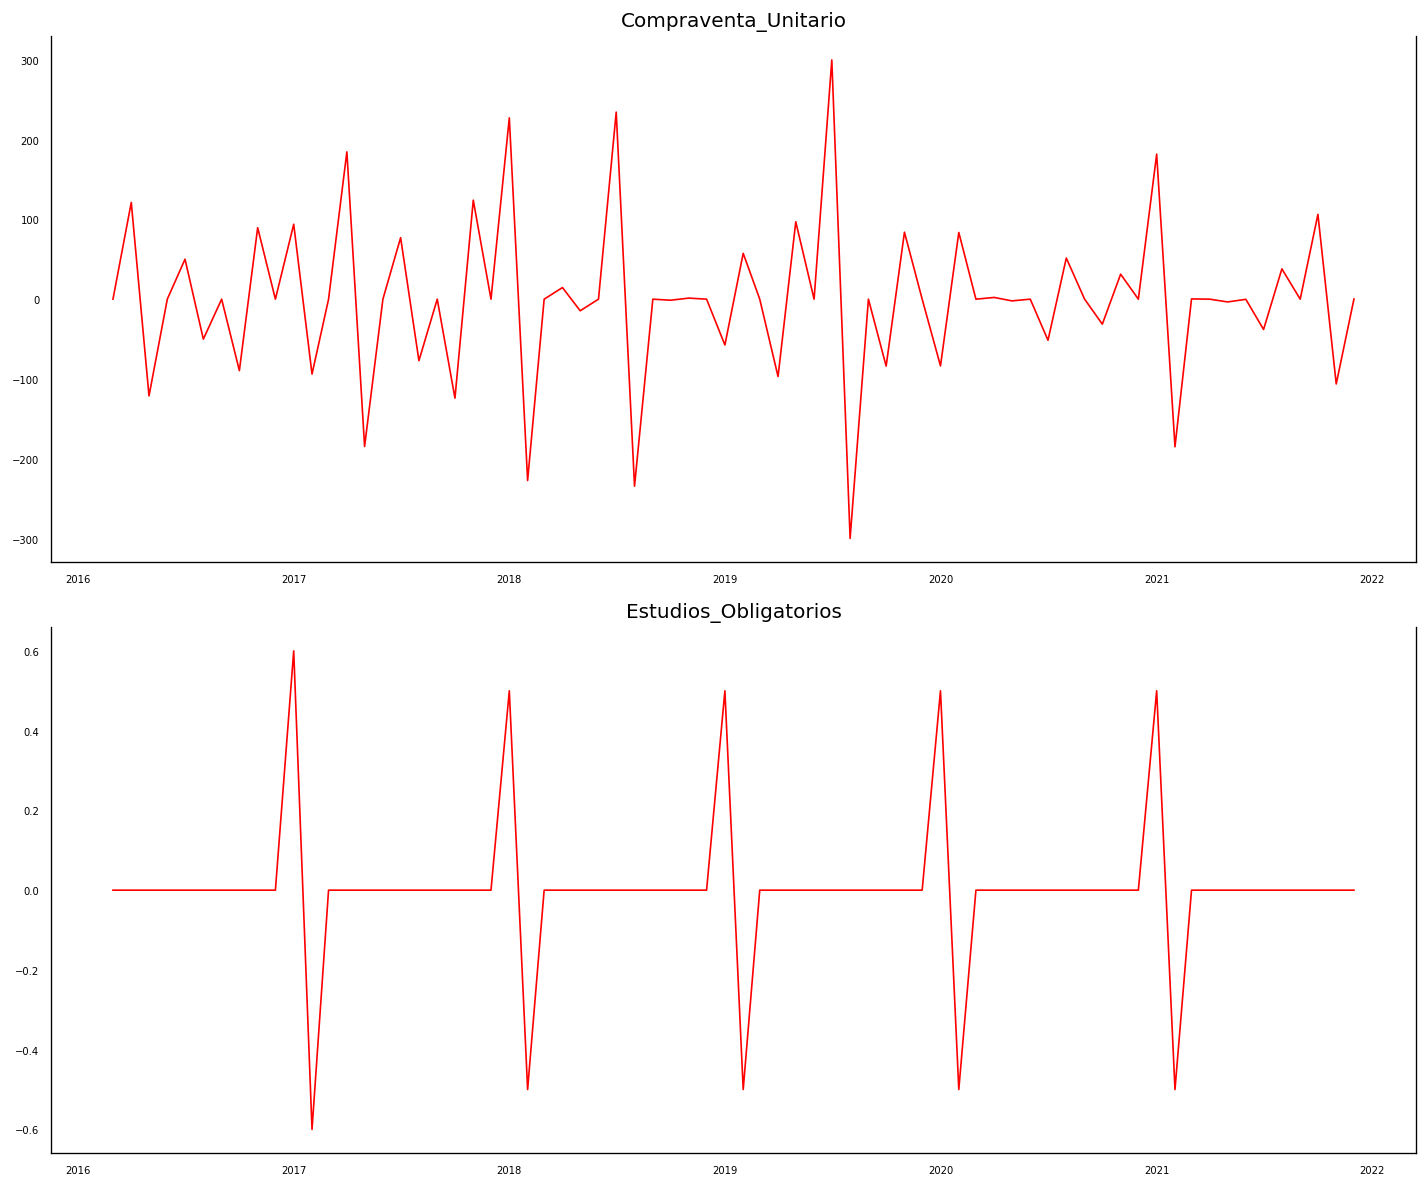

In [26]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,10))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000002
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

In [28]:
from statsmodels.tsa.api import VAR

In [29]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [41]:
modelsel=model.select_order(22)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,6.177,6.255,481.4,6.206
1,5.768,6.002,320.0,5.856
2,5.741,6.131,311.8,5.888
3,5.706,6.252,301.9,5.912
4,5.762,6.464,320.8,6.027
5,5.489,6.347,246.1,5.813
6,5.438,6.451,236.4,5.821
7,5.502,6.672,256.0,5.944
8,5.470,6.795,253.1,5.971
9,5.609,7.090,298.9,6.169


#### Ajustando el modelo

In [42]:
res = model.fit(maxlags=20, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     09:56:41
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    2.84112
Nobs:                     50.0000    HQIC:                  0.899506
Log likelihood:          -52.5290    FPE:                    2.86531
AIC:                    -0.294593    Det(Omega_mle):        0.865025
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            -3.039041        17.932353           -0.169           0.865
L1.Compraventa_Unitario          -0.910391         0.376293           -2.419           0.0

La correlación entre los residuos de "Compraventa_Unitario" y "Estudios_Obligatorios" es de -0.804914, lo que sugiere una correlación negativa fuerte entre los residuos de estas dos variables en tu modelo.

In [43]:
X_train.columns

Index(['Compraventa_Unitario', 'Estudios_Obligatorios'], dtype='object')

###### Causalidad de Granger

In [44]:
grangercaus=res.test_causality(['Estudios_Obligatorios'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.6736,2.191,0.804,"(20, 18)"


In [45]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Estudios_Obligatorios'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.4164,2.191,0.970,"(20, 18)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [46]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=20
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Estudios_Obligatorios_x
Compraventa_Unitario_y,1.0,0.0001
Estudios_Obligatorios_y,0.0,1.0000


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de Estudios_Obligatorios

###### Diagnosis del modelo


###### Residuos

In [47]:
residuals=res.resid

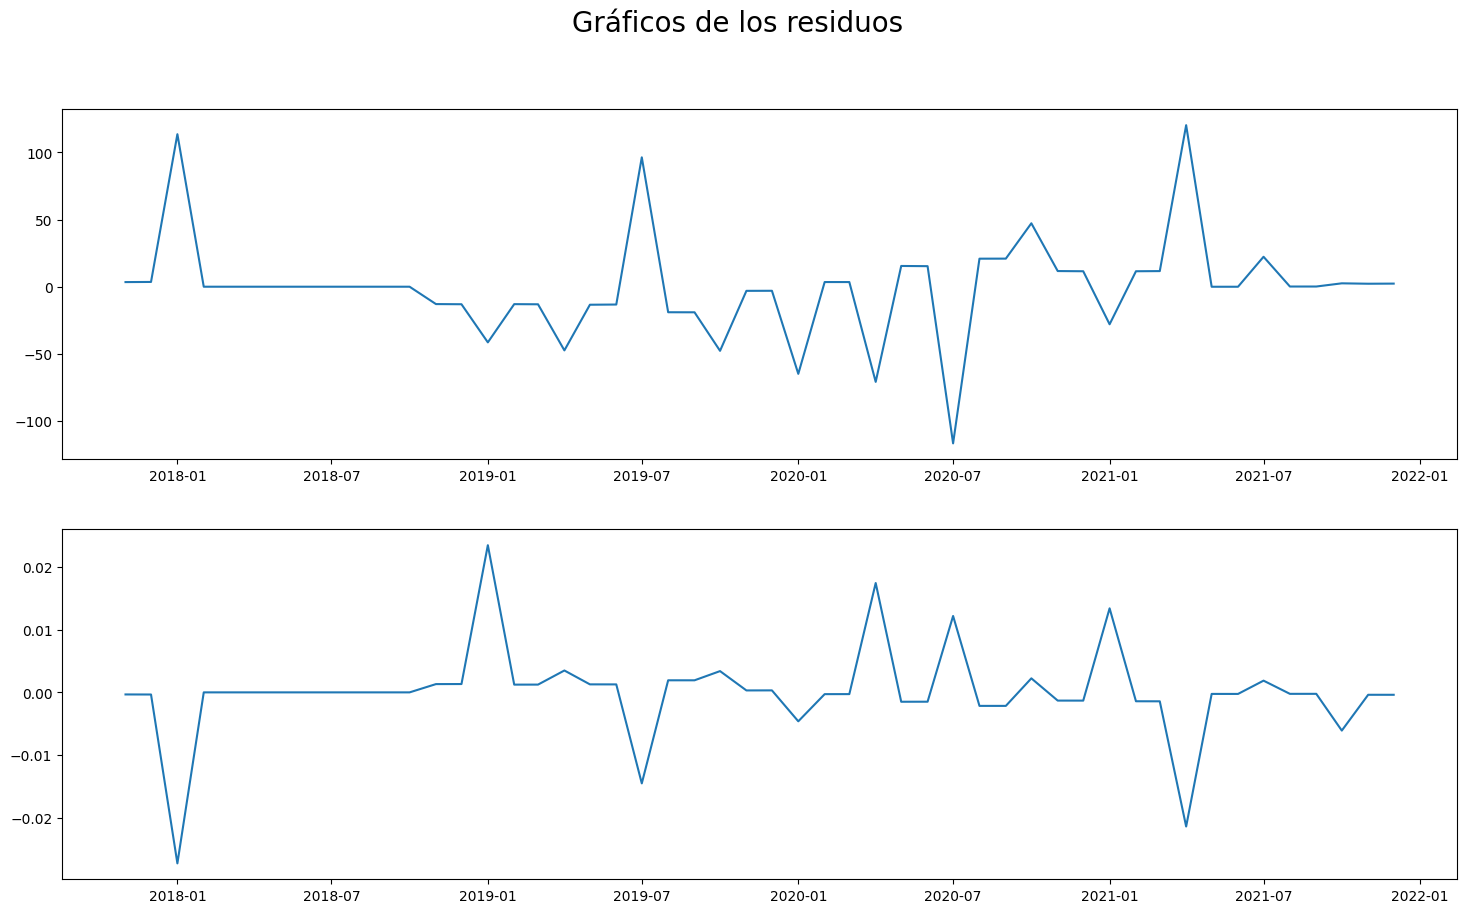

In [48]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [49]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[1.1116599599943507e-09, 0.008270910338291824]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


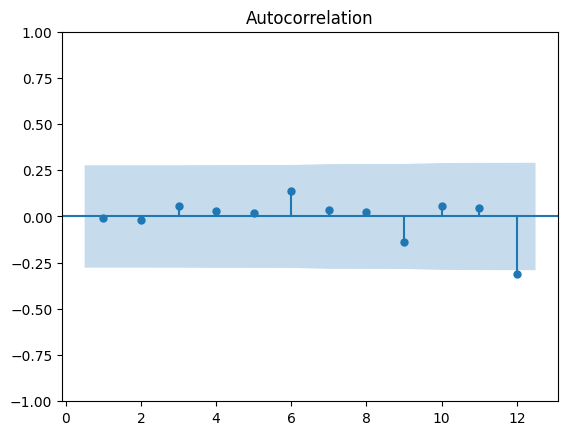

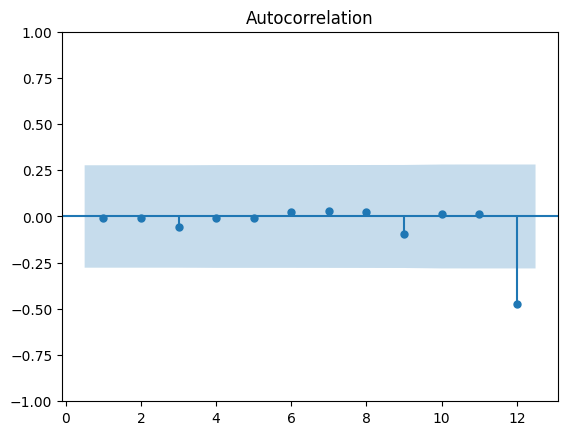

In [50]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


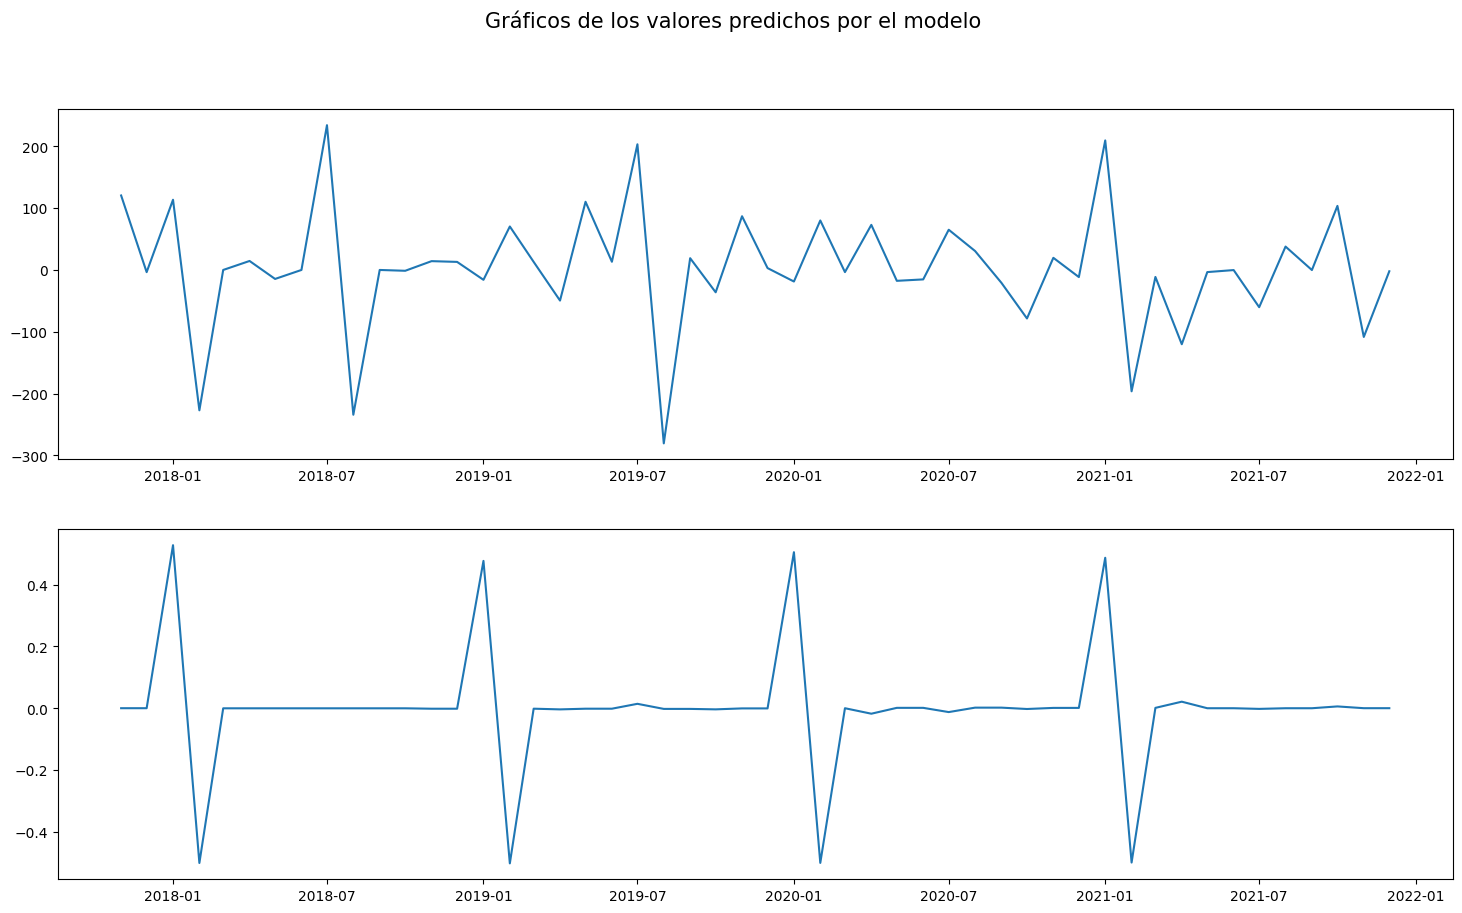

In [51]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [52]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 20
Predicciones:


,Compraventa_Unitario_pred,Estudios_Obligatorios_pred
Fecha,,
2022-01-01,46.134376,0.458326
2022-02-01,-43.645127,-0.458518
2022-03-01,-0.097139,0.000043
2022-04-01,-113.033598,0.041294
2022-05-01,121.192153,-0.042118
2022-06-01,0.223459,-0.000033
2022-07-01,241.467062,-0.002174
2022-08-01,-250.745458,0.003081
2022-09-01,-0.060399,0.000055


<Figure size 1200x1000 with 0 Axes>

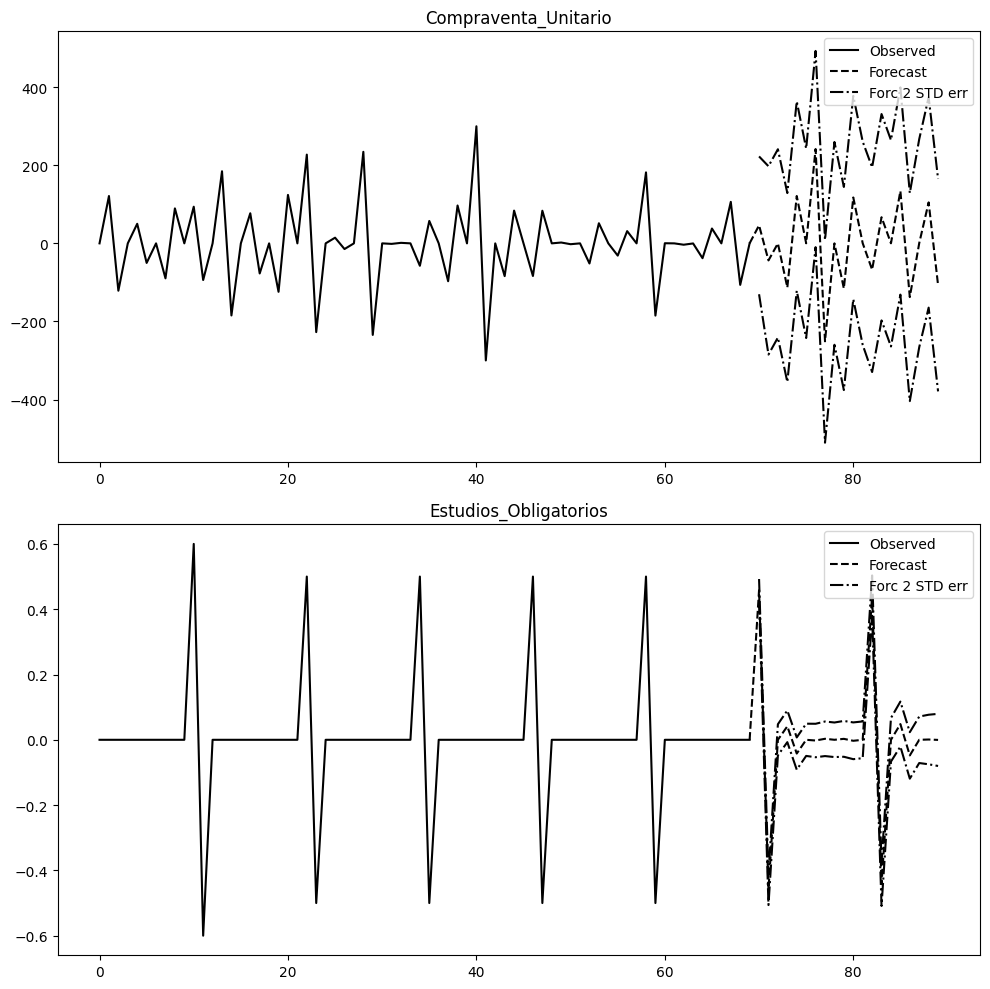

In [53]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [54]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [55]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2022-01-01,2425.500054,97.158326
2022-02-01,2421.611171,97.158135
2022-03-01,2417.625149,97.157987
2022-04-01,2300.605529,97.199133
2022-05-01,2304.778062,97.198160
2022-06-01,2309.174053,97.197155
2022-07-01,2555.037107,97.193975
2022-08-01,2550.154703,97.193877
2022-09-01,2545.211900,97.193834


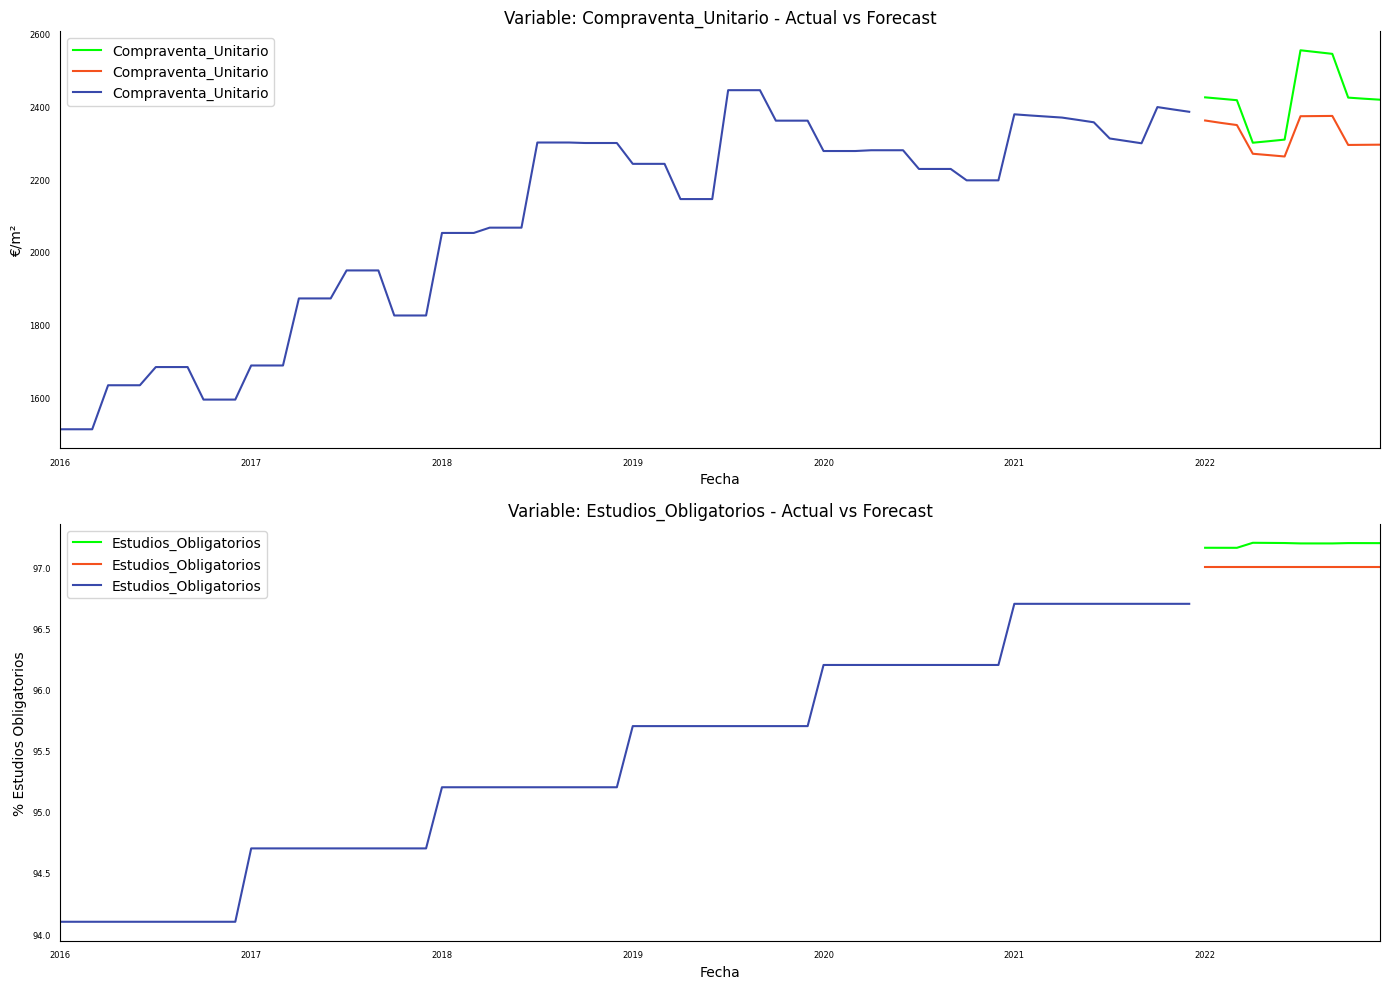

In [56]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Estudios Obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [57]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [58]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 13273.156565392068
MAE is : 101.929304354737
RMSE is : 115.20918611548329
MAPE is : 4.36455515414256
R2 is : -5.923956805224103

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.035118545191929536
MAE is : 0.1866680595356236
RMSE is : 0.18739942687193453
MAPE is : 0.19244129849033362
R2 is : 0.0



Los resultados de la evaluación muestran que el modelo tiene un rendimiento deficiente para la predicción de la variable "Compraventa_Unitario", como lo indica el alto MSE y RMSE, así como el valor negativo de R2, lo que sugiere que el modelo no explica bien la variabilidad de los datos. Sin embargo, para la variable "Estudios_Obligatorios", el modelo parece ajustarse mejor, con un MSE y RMSE más bajos y un R2 de 0, lo que indica un buen ajuste a los datos. En resumen, el modelo tiene un desempeño aceptable para la predicción de "Estudios_Obligatorios", pero necesita mejorar significativamente para predecir "Compraventa_Unitario".

In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 51.05798620713631
Root mean squared error: 81.46530452879085


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [60]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [61]:
fecha_division = '2022-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(72, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [62]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.394307
Serie de tiempo Estudios_Obligatorios
p-value: 0.906536


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [63]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-02-01,0.000000,0.0
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,0.000000,0.0
2016-06-01,0.000000,0.0


In [64]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.255095


In [65]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Estudios_Obligatorios
Fecha,,
2016-03-01,0.000000,0.0
2016-04-01,121.169231,0.0
2016-05-01,-121.169231,0.0
2016-06-01,0.000000,0.0
2016-07-01,50.076923,0.0


In [66]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000002
Serie de tiempo transformada Variable Estudios_Obligatorios
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [68]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [69]:
cointegration_test(X_train_transformed[['Compraventa_Unitario','Estudios_Obligatorios']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  55.52     > 12.3212   =>   True
Estudios_Obligatorios >  23.09     > 4.1296    =>   True


Los resultados del test de Cointegracion entre las dos series temporales son satisfactorios.

Para "Compraventa_Unitario", el valor del estadístico de prueba es 55.52, lo cual es mucho mayor que el valor crítico de 12.3212 al 95% de confianza. Esto indica que hay evidencia significativa de cointegración para esta variable.

Para "Estudios_Obligatorios", el valor del estadístico de prueba es 23.09, nuevamente mucho mayor que el valor crítico de 4.1296 al 95% de confianza. Esto también indica que hay evidencia significativa de cointegración para esta variable.

A pesar de las fluctuaciones a corto plazo, ambas variables tienden a moverse juntas en el largo plazo. Esto es importante para la modelización y el análisis de series temporales, ya que proporciona información sobre la relación a largo plazo entre las variables y puede ayudar en la construcción de modelos más precisos y en la formulación de políticas adecuadas.

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [70]:
import pmdarima as pm

In [71]:

pq = []
for name in ['Compraventa_Unitario', 'Estudios_Obligatorios']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=847.866, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=830.003, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=828.152, Time=0.17 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=823.038, Time=0.54 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=821.143, Time=0.62 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.22 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=823.142, Time=0.58 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0]          
Total fit time: 4.777 seconds
optimal order for:Compraventa_Unitario is: (4, 0, 0) 


Searching order of p and q for : Estudios_Obligatorios
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-26.699, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]           

#####Seleccion del modelo

In [72]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [73]:
pq

[(4, 0, 0), (4, 0, 0)]

Para la serie temporal de compraventa unitario

- *p=4:* Indica que se incluyen términos autoregresivos hasta el cuarto orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a sus valores en los cuatro periodos anteriores.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

Para la serie temporal de estudios obligatorios

- *p=4:* Indica que se incluyen términos autoregresivos hasta el cuarto orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a sus valores en los cuatro periodos anteriores.

- *q=0: *Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

In [75]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [76]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE Estudios_Obligatorios'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario','Estudios_Obligatorios']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'Estudios_Obligatorios']] , result, True)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Pmrmse = np.sqrt(metrics.mean_squared_error(X_test['Estudios_Obligatorios'], inv_res.Estudios_Obligatorios))

        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse,Pmrmse]


Grid Search Started
 Running for (4, 0, 0)
 Running for (4, 0, 0)


In [77]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE Estudios_Obligatorios'] )

,p,q,RMSE Compraventa_Unitario,RMSE Estudios_Obligatorios
0,4.0,0.0,119.027696,0.023619
1,4.0,0.0,119.027696,0.023619


#### Pronósticos a futuro


In [78]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'Estudios_Obligatorios']], order=(4,0)).fit(disp=False)
result = model.forecast(steps = 12)

In [79]:
result

,Compraventa_Unitario,Estudios_Obligatorios
2022-01-01,1.152469,-0.043156
2022-02-01,25.357554,0.052476
2022-03-01,5.885087,0.006723
2022-04-01,-21.406320,-0.016239
2022-05-01,2.584715,-0.007209
2022-06-01,1.858898,-0.000997
2022-07-01,4.989690,0.018192
2022-08-01,-2.220234,-0.002634
2022-09-01,-2.907457,-0.004745
2022-10-01,1.485729,0.000118


#### Invertiendo la transformacion de los pronosticos a la escala original

In [80]:
res = inverse_diff(df[['Compraventa_Unitario', 'Estudios_Obligatorios']],result,True)

In [81]:
res

,Compraventa_Unitario,Estudios_Obligatorios
2022-01-01,2296.751031,96.956844
2022-02-01,2323.636845,96.966163
2022-03-01,2356.407746,96.982207
2022-04-01,2367.772328,96.982011
2022-05-01,2381.721624,96.974606
2022-06-01,2397.529819,96.966204
2022-07-01,2418.327703,96.975994
2022-08-01,2436.905353,96.983150
2022-09-01,2452.575547,96.985561
2022-10-01,2469.731471,96.988089


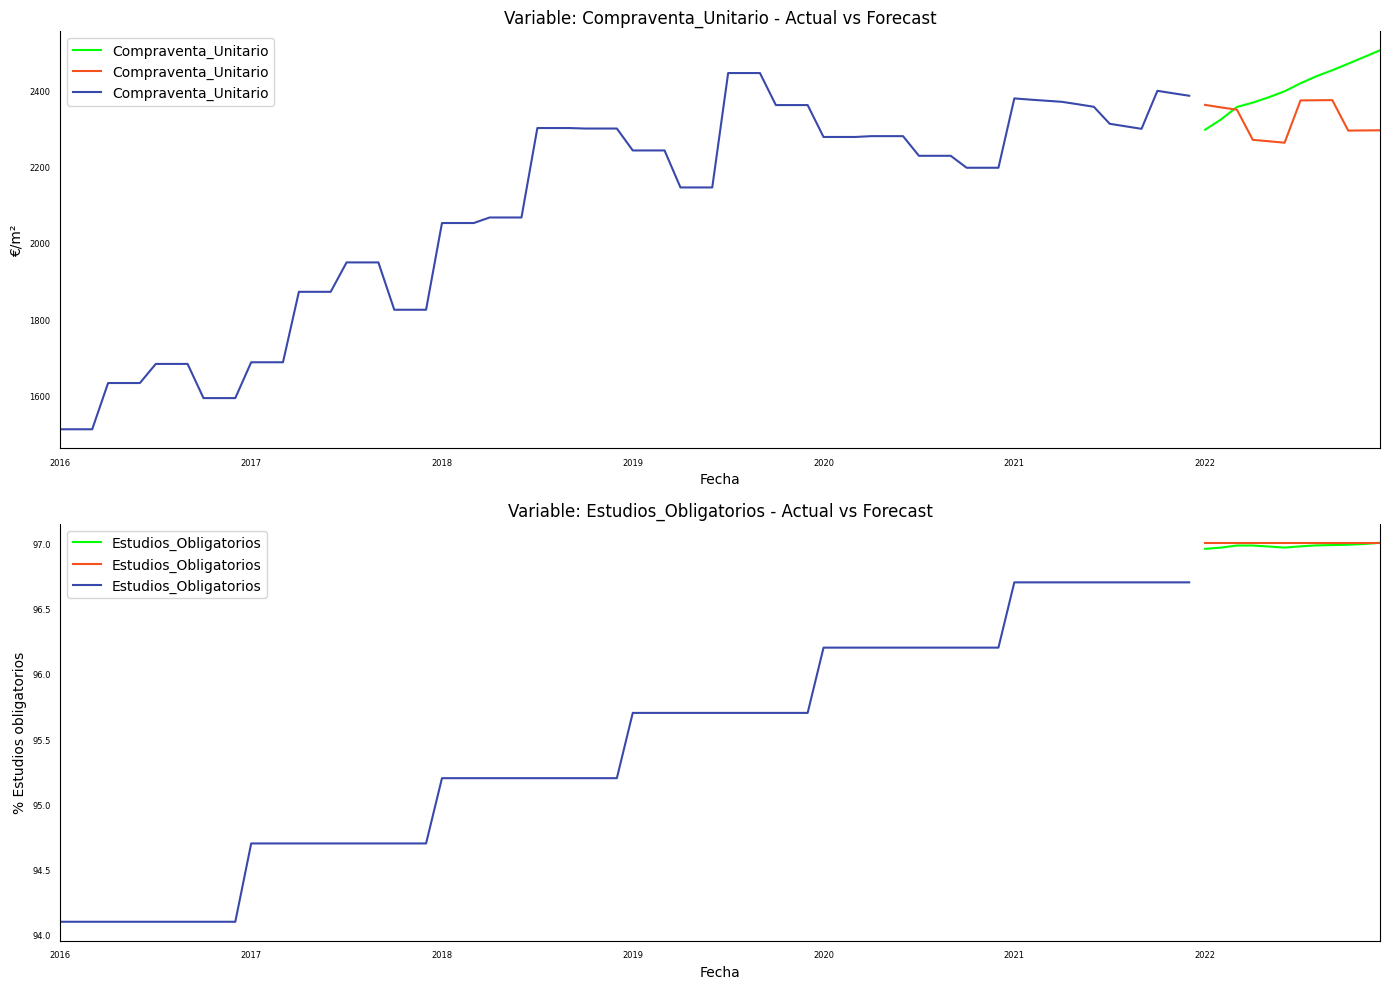

In [82]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Estudios obligatorios']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [83]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [84]:
for i in ['Compraventa_Unitario','Estudios_Obligatorios']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 14167.592457147015
MAE is : 101.21307262601886
RMSE is : 119.02769617675969
MAPE is : 4.39370004329577
R2 is : -6.390540277591245

Evaluation metric for Estudios_Obligatorios
Evaluation metric results:-
MSE is : 0.0005578576654813775
MAE is : 0.02071526260573601
RMSE is : 0.023619010679564408
MAPE is : 0.021355940830655687
R2 is : 0.0



Los resultados sugieren que el modelo VARMAX tiene un rendimiento dispar entre las variables "Compraventa_Unitario" y "Estudios_Obligatorios". Mientras que el modelo parece adecuado para predecir "Estudios_Obligatorios", muestra deficiencias en la predicción de "Compraventa_Unitario". Se requiere una revisión más detallada para mejorar la capacidad predictiva del modelo, posiblemente mediante la inclusión de más variables explicativas. Estos hallazgos resaltan la importancia de ajustar el modelo VARMAX de manera específica para cada variable objetivo. Es necesario continuar refinando el modelo para garantizar su utilidad en la predicción precisa de ambas variables.

In [85]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 50.616893944312295
Root mean squared error: 84.16529277262892


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_Unitario y estudios obligatorios tenemos que:

- Se ha comprobado que las variables tienen una alta correlacion.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad, con una diferenciacion de segunda orden lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido positiva, lo que quiere decir una serie temporal puede predecir la otra serie temporal. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado positivo, lo que significa que las series estan relacionadas en el tiempo y que seria mas acosnsejable un modelo VAR.

Si atendemos a las evaluaciones del modelo, la serie temporal de compraventa tiene mejor evaluacion en el modelo VAR, mientras que en la serie temporal de estudios obligatorios tiene mejor indicador el modelo VARMAX

